In [3]:
from brian2 import *
%matplotlib inline

import sys
sys.path.append('../resonnant')
import resonnant as rs
reload(rs)
import pandas as pd
import neuraltda.topology as tp
reload(tp)

WARNING    /Users/brad/anaconda/envs/neuraltda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
 [py.warnings]


<module 'neuraltda.topology' from '/Users/brad/GentnerLab/code/NeuralTDA/neuraltda/topology.pyc'>

WARNING    "t" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value array([   0.        ,    0.11951952,    0.23903904,    0.35855856,
          0.47807808,    0.5975976 ,    0.71711712,    0.83663664,
          0.95615616,    1.07567568,    1.1951952 ,    1.31471471,
          1.43423423,    1.55375375,    1.67327327,    1.79279279,
          1.91231231,    2.03183183,    2.15135135,    2.27087087,
          2.39039039,    2.50990991,    2.62942943,    2.74894895,
          2.86846847,    2.98798799,    3.10750751,    3.22702703,
          3.34654655,    3.46606607,    3.58558559,    3.70510511,
          3.82462462,    3.94414414,    4.06366366,    4.18318318,
          4.3027027 ,    4.42222222,    4.54174174,    4.66126126,
          4.78078078,    4.9003003 ,    5.01981982,    5.13933934,
          5.25885886,    5.37837838,    5.4978979 ,    5.61741742,
          5.73693694,    5.85645646,    5.97597598,    6.0954955 ,
          6.

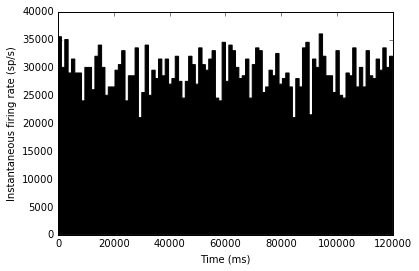

In [77]:
start_scope()

N = 20
tau = 10*ms
vr = -70*mV
vt0 = -50*mV
delta_vt0 = 5*mV
tau_t = 100*ms
sigma = 0.55*(vt0-vr)
v_drive = 0*(vt0-vr)
duration = 120000*ms
f = 2*Hz
a = 0*mV

eqs = '''
dv/dt = (v_drive+vr-v)/tau + sigma*xi*tau**-0.5 + (a/tau)*sin(2*3.1416*f*t): volt
dvt/dt = (vt0-vt)/tau_t : volt
'''

reset = '''
v = vr
vt += delta_vt0
'''

G = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')

# Synapses
psyn = 1
S = Synapses(G, G, model='w : volt', on_pre='v += w')
S.connect(condition='i != j', p=psyn)
S.w[:, :] = '2*rand()*mV'
S.delay[:, :] = '5*rand()*ms'

spikemon = SpikeMonitor(G)

G.v = 'rand()*(vt0-vr)+vr'
G.vt = vt0

run(duration)

_ = hist(spikemon.t/ms, 100, histtype='stepfilled', facecolor='k', weights=ones(len(spikemon))/(N*defaultclock.dt))
xlabel('Time (ms)')
ylabel('Instantaneous firing rate (sp/s)');

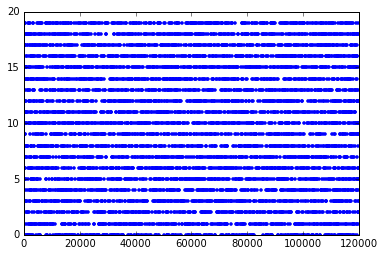

In [78]:

plot(spikemon.t/ms, spikemon.i, '.')

# Test brian2ephys

In [79]:
brianTri = [spikemon, spikemon]
stims = ['teststim', 'teststim']
trialLen = 120.0
iti = 5.0
fs = 20000
(spikes, trials) = rs.brian2ephys(brianTri, stims, trialLen, iti, fs)
clusters = pd.DataFrame({'cluster': range(N), 'quality': N*['Good']})

# Test binning Brian2 output

In [80]:
ncellsperm = N-10
nperms = 20
nshuffs = 1
bfdict = tp.do_dag_bin('../',spikes, trials, clusters, fs, 25.0, {'period': 1}, ncellsperm, nperms, nshuffs)

In [81]:
tp.dag_topology('../',4.0, bfdict)

In [82]:
import pickle
with open('../20161021T161625Z-25.0-4.0-masterResults.pkl') as f:
    mrRes = pickle.load(f)

In [ ]:
permbinfold = bfdict['permuted']


In [65]:
from scipy.interpolate import interp1d
def plotBettiCurveRecursive(resDict):
    
    if 'bettis' in resDict.keys():
        bettiDat = resDict['bettis']
        bettis = len(bettiDat[0][1])
        for betti in range(bettis):
            ycoords = [s[1][betti] for s in bettiDat]
            xcoords = [s[0] for s in bettiDat]
            fig = plt.figure()
            plt.plot(np.transpose(xcoords), np.transpose(ycoords))
            plt.title('Hstr: %s  Betti: %s' % (resDict['hstr'], betti))
            plt.show()
    else:
        for ind, k in enumerate(resDict.keys()):
            plotBettiCurveRecursive(resDict[k])
            
def avgBettiRecursive(bettiDict, bettinum, runningSum, N, maxT):
    if 'bettis' in bettiDict.keys():
        bettiT = np.array([s[0] for s in bettiDict['bettis']])*(windt/1000.)
        maxT = max(bettiT)
        try:
            bettiB = np.array([s[1][bettinum] for s in bettiDict['bettis']])
        except:
            
            bettiB = np.zeros(len(bettiT))
        bfunc = interp1d(bettiT, bettiB, kind='zero', bounds_error=False, fill_value=(bettiB[0], bettiB[-1]))
        t = np.linspace(0, maxT, 1000)
        bvals = bfunc(t)
        return (runningSum + bvals, N+1, maxT)
    else:
        for k in bettiDict.keys():
            runningSum, N, maxT = avgBettiRecursive(bettiDict[k], bettinum, runningSum, N, maxT)
        return (runningSum, N, maxT)
    
def computeAvgBettiCurve(resDict, stim, betti):
    
    stimdata = resDict[stim]
    
    runningSum, N, maxT = avgBettiRecursive(stimdata, betti, np.zeros(1000), 0, 0)
    avgBetti = runningSum / float(N)
    t = np.linspace(0, maxT, len(avgBetti))
    
    return (avgBetti, t, maxT)
    
def plotAvgBettiCurves(avgBetti, t, betti): 
    plt.figure()
    plt.plot(t, avgBetti)
    plt.title('Stim: %s Betti: %d' %('s', betti))
    plt.ylim([0, max(avgBetti)+2])
    plt.xlim([0, max(t)])
    plt.show()

In [63]:
maxT

119.40000000000001

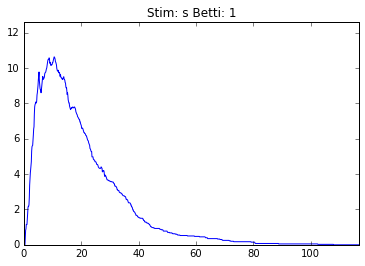

In [83]:
betti = 1
windt = 25.0
avgBetti, t, maxT = computeAvgBettiCurve(mrRes['permuted'], 'teststim', betti)
plotAvgBettiCurves(avgBetti, t, betti)


In [ ]:
max(betti1) = N neurons?